In [13]:
import torch
import sys
from pathlib import Path
import os
import matplotlib.pyplot as plt
sys.path.insert(0, str(Path(os.path.abspath('')).parent))
from utils import setup_data_loaders, get_sample, class_mask_to_rgb
from dataset.dataset import BackgroundDataset

In [14]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Plot sample

In [24]:
image, mask, matting, image_input, mask_input = get_sample("3", split_set="validation", device=DEVICE, go_parent_folder=True, width=384, height=512)

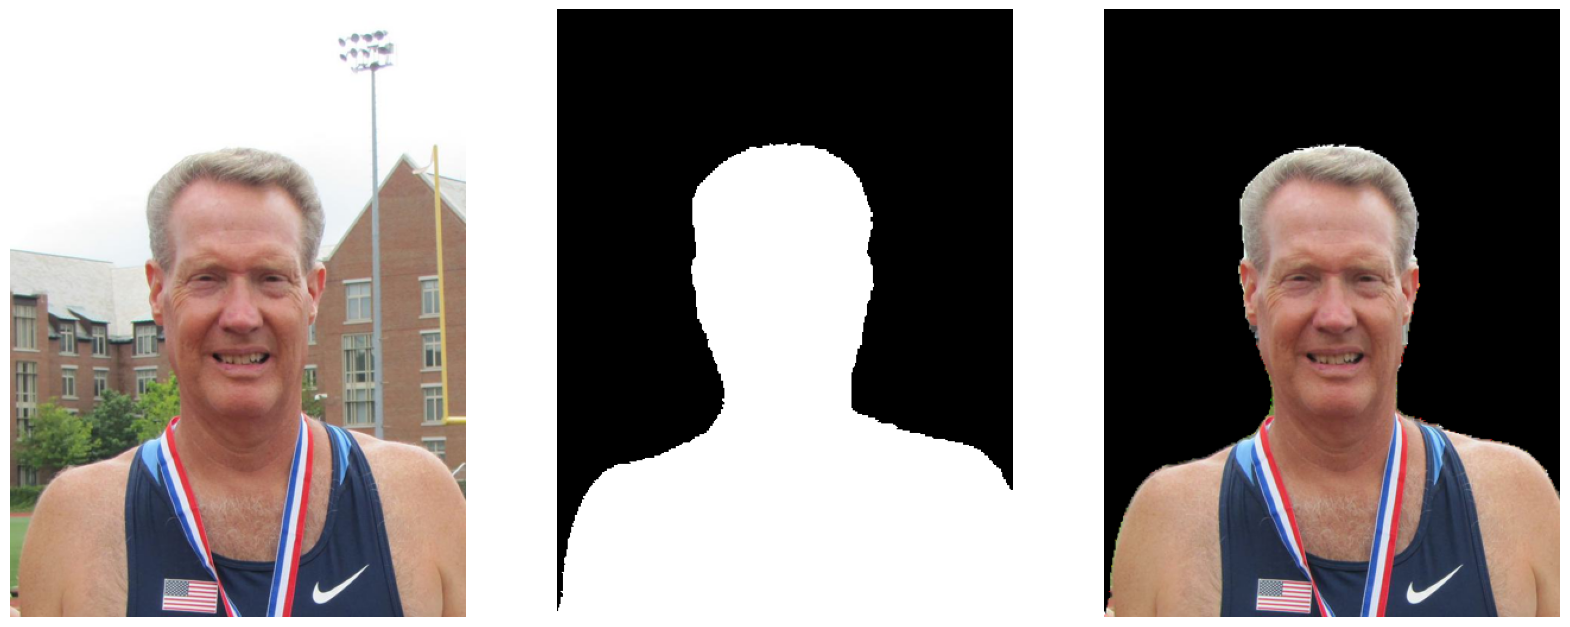

In [25]:
fig = plt.figure(figsize=(20, 10))
ax = fig.subplots(1, 3)
ax[0].imshow(image)
ax[0].axis("off")
ax[1].imshow(mask, cmap="gray")
ax[1].axis("off")
ax[2].imshow(matting)
ax[2].axis("off")
plt.show()

Print the dimensions of an image and a mask:

In [17]:
# Print the dimensions of an image and a mask:
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

Image shape: (512, 384, 3)
Mask shape: (512, 384)


## Dataset

In [18]:
DATA_FOLDER = os.path.join("..", "data")
    
train_dataset = BackgroundDataset(DATA_FOLDER, "training", True, image_height=512, image_width=384)

# print the shape of a random image and its mask
image, mask = train_dataset[1]
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

Image shape: torch.Size([3, 512, 384])
Mask shape: torch.Size([1, 512, 384])


In [19]:
image = image.permute(1, 2, 0)
mask = mask.squeeze(0)

In [20]:
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

Image shape: torch.Size([512, 384, 3])
Mask shape: torch.Size([512, 384])


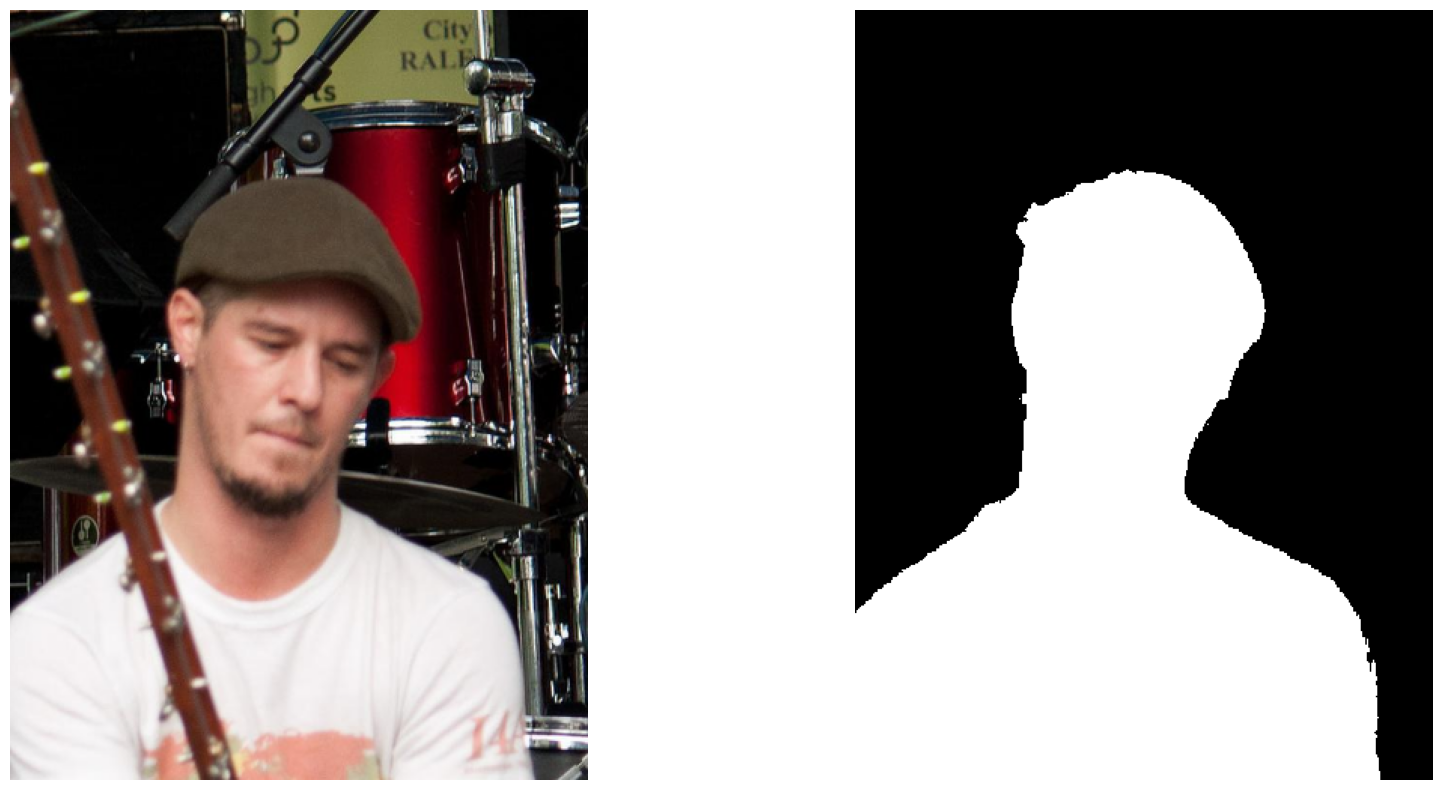

In [21]:
fig = plt.figure(figsize=(20, 10))
ax = fig.subplots(1, 2)
ax[0].imshow(image)
ax[0].axis("off")
ax[1].imshow(mask, cmap="gray")
ax[1].axis("off")
plt.show()